In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Load the data
customers_df = pd.read_csv(r"C:\Users\bmoha\Downloads\Customers.csv")
transactions_df = pd.read_csv(r"C:\Users\bmoha\Downloads\Transactions.csv")
customers_df.head()
transactions_df.head()


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [11]:
# Strip any spaces from column names
customers_df.columns = customers_df.columns.str.strip()
transactions_df.columns = transactions_df.columns.str.strip()

In [23]:
# Merge Customers.csv with Transactions.csv on CustomerID
merged_df = transactions_df.merge(customers_df, on="CustomerID", how="left")

In [25]:
# Feature Engineering
# Create customer-level aggregated features from transactions
customer_features = merged_df.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spending
    "TransactionID": "count",  # Number of transactions
    "Quantity": "sum"  # Total quantity purchased
}).rename(columns={
    "TotalValue": "TotalSpending",
    "TransactionID": "TransactionCount",
    "Quantity": "TotalQuantity"
}).reset_index()

In [27]:
# Merge customer features with profile info
customer_data = customers_df.merge(customer_features, on="CustomerID", how="left").fillna(0)

In [29]:
# Select numerical features for clustering
features = customer_data[["TotalSpending", "TransactionCount", "TotalQuantity"]]

In [31]:
# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)



In [35]:
# Perform clustering with KMeans for 2-10 clusters and compute DB Index
db_scores = []
kmeans_models = {}

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, clusters)
    db_scores.append((n_clusters, db_index))
    kmeans_models[n_clusters] = kmeans

C:\Users\bmoha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bmoha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bmoha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bmoha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [37]:
# Find the best number of clusters based on the lowest DB Index
best_n_clusters, best_db_index = min(db_scores, key=lambda x: x[1])
best_kmeans = kmeans_models[best_n_clusters]

In [41]:
# Assign clusters to the data
customer_data["Cluster"] = best_kmeans.labels_

In [43]:

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

In [45]:

# Add PCA results to the DataFrame for visualization
customer_data["PCA1"] = pca_features[:, 0]
customer_data["PCA2"] = pca_features[:, 1]

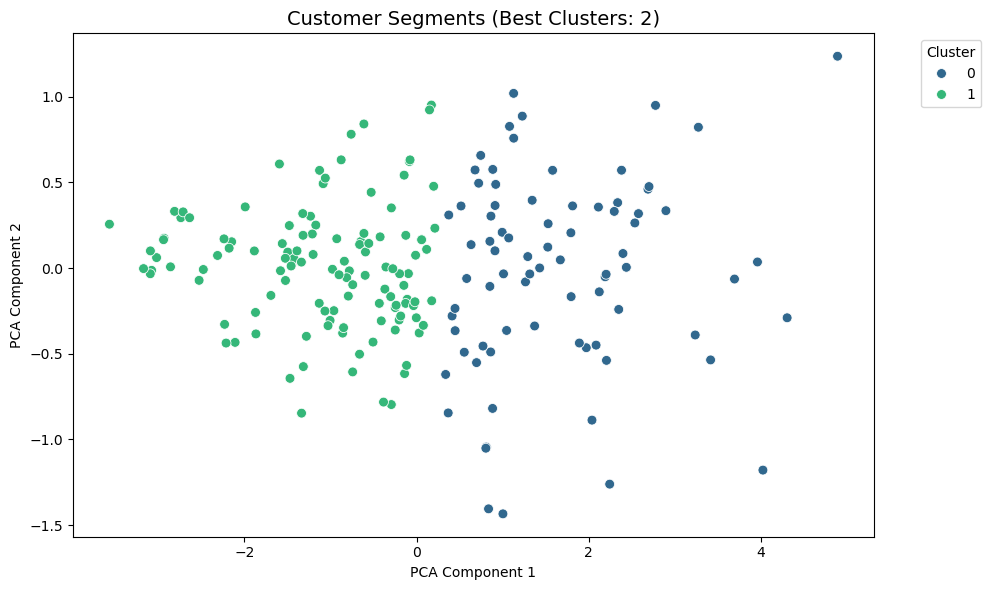

In [59]:
# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", s=50)
plt.title(f"Customer Segments (Best Clusters: {best_n_clusters})", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [49]:
# Report the results
print(f"Best Number of Clusters: {best_n_clusters}")
print(f"Davies-Bouldin Index: {best_db_index:.4f}")
print("DB Scores for Clusters:")
for n, score in db_scores:
    print(f"{n} Clusters: DB Index = {score:.4f}")

Best Number of Clusters: 2
Davies-Bouldin Index: 0.7235
DB Scores for Clusters:
2 Clusters: DB Index = 0.7235
3 Clusters: DB Index = 0.7686
4 Clusters: DB Index = 0.8052
5 Clusters: DB Index = 0.8950
6 Clusters: DB Index = 0.9210
7 Clusters: DB Index = 0.9029
8 Clusters: DB Index = 0.9593
9 Clusters: DB Index = 0.9583
10 Clusters: DB Index = 0.9924


In [51]:
# Save the clustered data
customer_data.to_csv("Clustered_Customers.csv", index=False)
print("Clustered data saved to 'Clustered_Customers.csv'")

Clustered data saved to 'Clustered_Customers.csv'


In [53]:
import os
print("File saved at:", os.path.abspath("Clustered_Customers.csv"))

File saved at: C:\Users\bmoha\Clustered_Customers.csv
